# 策略：4部份

In [1]:
import pandas as pd
import numpy as np
import random
import gc
import seaborn as sns
import lightgbm as lgb
from matplotlib import pyplot as plt
# import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.metrics import recall_score, auc, accuracy_score, f1_score, precision_score, classification_report, roc_auc_score,mean_squared_error
from pandas.api.types import is_categorical_dtype
from pandas.api.types import is_datetime64_any_dtype as is_datetime
# import missingno as msno
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

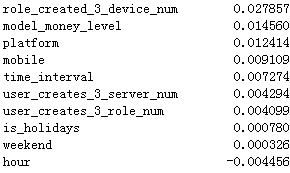

In [4]:
# 删除相关性小的特征
data = pd.read_pickle('./data.pickle')
select_features = ['user_id','cp_server_no','cp_role_id','role_created_3_login_num',
       'role_created_3_active', 'role_created_3_online',
       'role_created_3_max_role_level', 'role_created_3_ip_num',
       'role_created_3_pay_num', 'role_created_3_pay_sum', 'active_0-8', 'active_8-12', 'active_12-14',
       'active_14-18', 'active_18-24', 'pay_grade_1', 'pay_grade_2',
       'pay_grade_3', 'pay_grade_4', 'pay_grade_5', 'pay_grade_6',
       'role_created_3_pay_rate', 'role_created_3_pay_avg']
label = ['role_created_30_pay_sum']
df = data[select_features].join(data[label])
df['role_created_30_pay_sum'].fillna(0,inplace=True)

In [54]:
# 将数据分为:1、前3天无付费有活跃;  2、前3天有付费，付费金额小于1000；3、前3天有付费，付费金额大于1000;4、前3天无付费且无活跃;
df_train, df_test = train_test_split(df,test_size=0.3)
df_train_3_pay = df_train[df_train['role_created_3_pay_sum']>0]
df_train_3_nopay = df_train[df_train['role_created_3_pay_sum']==0]
df_train_3_nopay_online_n = df_train_3_nopay[(df_train_3_nopay['role_created_3_online']==907) | (df_train_3_nopay['role_created_3_login_num']<3)|(df_train_3_nopay['role_created_3_max_role_level']==1)]
df_train_3_nopay_online_y = df_train_3_nopay.loc[np.setdiff1d(df_train_3_nopay.index, df_train_3_nopay_online_n.index),:]
df_train_3_pay_r = df_train_3_pay[df_train_3_pay['role_created_3_pay_sum']>=1000]
df_train_3_pay_nor = df_train_3_pay[df_train_3_pay['role_created_3_pay_sum']<1000]

## Train part 1 _前3天无付费有活跃

In [49]:
df_train_3_nopay_online_y['role_created_30_pay_sum'].sum()


3346350.0

In [53]:
df_train_3_nopay_online_y['role_created_30_pay_sum'].mean()

5.420498225482748

In [51]:
df_train_3_nopay_online_y.shape

(617351, 24)

In [52]:
df_train_3_nopay_online_y[df_train_3_nopay_online_y['role_created_30_pay_sum']>0].shape

(13407, 24)

## Train part 2 _前3天付费且金额<1000

In [55]:
df_train_3_pay_nor['role_created_30_pay_sum'].sum()

30199971.0

In [57]:
df_train_3_pay_nor['role_created_30_pay_sum'].mean()

428.2833338060527

In [58]:
df_train_3_pay_nor.shape

(70514, 24)

In [59]:
target = df_train_3_pay_nor['role_created_30_pay_sum']
features = df_train_3_pay_nor.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
target_ln = np.log1p(target)

X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)
params = {

'boosting_type':'gbdt',
'objective':'regression',
'metric':'rmse',
'nthread':4,
'learning_rate':0.05,
"max_depth":5,
"num_leaves":20,
"max_bin":255,
"min_data_in_leaf":61,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":1.0,
"bagging_freq":45,
"lambda_l1":1,
"lambda_l2":0.4,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_p2 = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])


[1]	training's rmse: 1.55794	valid_1's rmse: 1.57038
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.51059	valid_1's rmse: 1.52311
[3]	training's rmse: 1.4665	valid_1's rmse: 1.47904
[4]	training's rmse: 1.42551	valid_1's rmse: 1.43819
[5]	training's rmse: 1.38746	valid_1's rmse: 1.40022
[6]	training's rmse: 1.35215	valid_1's rmse: 1.36498
[7]	training's rmse: 1.31933	valid_1's rmse: 1.33223
[8]	training's rmse: 1.289	valid_1's rmse: 1.30199
[9]	training's rmse: 1.26092	valid_1's rmse: 1.27399
[10]	training's rmse: 1.23503	valid_1's rmse: 1.24817
[11]	training's rmse: 1.21114	valid_1's rmse: 1.22437
[12]	training's rmse: 1.18906	valid_1's rmse: 1.20235
[13]	training's rmse: 1.16879	valid_1's rmse: 1.18208
[14]	training's rmse: 1.15012	valid_1's rmse: 1.16341
[15]	training's rmse: 1.13295	valid_1's rmse: 1.14631
[16]	training's rmse: 1.11725	valid_1's rmse: 1.13058
[17]	training's rmse: 1.10281	valid_1's rmse: 1.11622
[18]	training's rmse: 1.08955	va

[214]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[215]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[216]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[217]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[218]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[219]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[220]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[221]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[222]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[223]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[224]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[225]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[226]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[227]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[228]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[229]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[230]	training's rmse: 0.936214	valid_1's rmse: 0.962845
[231]	training's rmse: 0.936214

In [72]:
y_predict_p2 = lgb_p2.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict_p2)*1.86, np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict_p2)*1.86, np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

1802.884256726747
3250391.643153155
413.3192833662707


In [73]:
sum(np.expm1(y_predict_p2)) * 1.86

8981893.634431582

In [75]:
sum(np.expm1(y_predict_p2)* 1.86) /sum(np.expm1(y_test))

0.9543941097642289

## Train part 3 _前3天付费且金额>=1000

In [76]:
df_train_3_pay_r['role_created_30_pay_sum'].sum()

35548348.0

In [77]:
df_train_3_pay_r['role_created_30_pay_sum'].mean()

10265.188564828184

In [78]:
df_train_3_pay_r['role_created_30_pay_sum'].shape

(3463,)

In [79]:
# 对前n天有付费且金额大于1000的进行回归
target = df_train_3_pay_r['role_created_30_pay_sum']
features = df_train_3_pay_r.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
target_ln = np.log1p(target)
X_val, x_test, Y_val, y_test = train_test_split(features,target_ln, test_size=0.3)
params = {

'boosting_type':'gbdt',
'objective':'regression',
'metric':'rmse',
'nthread':4,
'learning_rate':0.05,
"max_depth":5,
"num_leaves":20,
"max_bin":255,
"min_data_in_leaf":61,
"min_split_gain":1.0,
"feature_fraction": 1.0,
"bagging_fraction":1.0,
"bagging_freq":45,
"lambda_l1":1,
"lambda_l2":0.4,
"metric": "rmse",
}
train_data = lgb.Dataset(X_val, label=Y_val)
val_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
lgb_p3 = lgb.train(params, train_data, num_boost_round=8000, early_stopping_rounds=100, valid_sets=[train_data, val_data])

[1]	training's rmse: 1.03441	valid_1's rmse: 1.05184
Training until validation scores don't improve for 100 rounds
[2]	training's rmse: 1.01063	valid_1's rmse: 1.02993
[3]	training's rmse: 0.988595	valid_1's rmse: 1.00989
[4]	training's rmse: 0.968217	valid_1's rmse: 0.991572
[5]	training's rmse: 0.949339	valid_1's rmse: 0.974455
[6]	training's rmse: 0.931983	valid_1's rmse: 0.958825
[7]	training's rmse: 0.915763	valid_1's rmse: 0.944547
[8]	training's rmse: 0.900797	valid_1's rmse: 0.931795
[9]	training's rmse: 0.88709	valid_1's rmse: 0.919924
[10]	training's rmse: 0.874517	valid_1's rmse: 0.909098
[11]	training's rmse: 0.862571	valid_1's rmse: 0.898709
[12]	training's rmse: 0.851876	valid_1's rmse: 0.889689
[13]	training's rmse: 0.841599	valid_1's rmse: 0.881611
[14]	training's rmse: 0.832236	valid_1's rmse: 0.873696
[15]	training's rmse: 0.823526	valid_1's rmse: 0.867118
[16]	training's rmse: 0.815183	valid_1's rmse: 0.860462
[17]	training's rmse: 0.807951	valid_1's rmse: 0.854343
[

In [88]:
y_predict_r = lgb_p3.predict(x_test)
mse = mean_squared_error(np.expm1(y_predict_r)*1.4, np.expm1(y_test))
mae = mean_absolute_error(np.expm1(y_predict_r)*1.4, np.expm1(y_test))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

10928.091264585573
119423178.6871115
6490.590847292033


In [82]:
sum(np.expm1(y_predict_r))

7740277.256941903

In [84]:
sum(np.expm1(y_test))

10915936.0

In [87]:
sum(np.expm1(y_predict_r))*1.4/sum(np.expm1(y_test))

0.9927126871867574

# 用df_test数据集进行测试

In [90]:
# 用df_test数据集进行测试
df_test_3_pay = df_test[df_test['role_created_3_pay_sum']>0]
df_test_3_nopay = df_test[df_test['role_created_3_pay_sum']==0]
df_test_3_nopay_online_n = df_test_3_nopay[(df_test_3_nopay['role_created_3_online']==907) | (df_test_3_nopay['role_created_3_login_num']<3)|(df_test_3_nopay['role_created_3_max_role_level']==1)]
df_test_3_nopay_online_y = df_test_3_nopay.loc[np.setdiff1d(df_test_3_nopay.index, df_test_3_nopay_online_n.index),:]
df_test_3_pay_r = df_test_3_pay[df_test_3_pay['role_created_3_pay_sum']>=1000]
df_test_3_pay_nor = df_test_3_pay[df_test_3_pay['role_created_3_pay_sum']<1000]

### part4

In [97]:
df_test_part4 = df_test_3_nopay_online_n[['user_id','cp_server_no','cp_role_id','role_created_3_pay_num']].rename(columns=
                                                                                {'role_created_3_pay_num':'predict_30_pay'})

In [98]:
df_test_part4.head()

,user_id,cp_server_no,cp_role_id,predict_30_pay
3560406,110248023,660645,16808756,0.0
1331539,103628574,660312,14657550,0.0
3713887,110701949,660675,16952950,0.0
2885298,108077794,660523,16164600,0.0
2262437,106395434,660441,15561287,0.0


### part1

In [99]:
df_test_part1 = df_test_3_nopay_online_y[['user_id','cp_server_no','cp_role_id','role_created_3_pay_num']].rename(columns=
                                                                                {'role_created_3_pay_num':'predict_30_pay'})
df_test_part1['predict_30_pay'] = 5.5

In [100]:
df_test_part1.head()

,user_id,cp_server_no,cp_role_id,predict_30_pay
4,90001842,660011,12927599,5.5
6,90001889,660011,12927601,5.5
34,90002980,660011,12927628,5.5
35,90003019,660011,12927630,5.5
50,90003339,660011,12927645,5.5


### part2

In [96]:
target_test = df_test_3_pay_nor['role_created_30_pay_sum']
target_test_ln = np.log1p(target_test)
features_test = df_test_3_pay_nor.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
y_predict_p2 = lgb_p2.predict(features_test)
y_predict_p2[y_predict_p2<0] = 0
mse = mean_squared_error(np.expm1(y_predict_p2), np.expm1(target_test_ln))
mae = mean_absolute_error(np.expm1(y_predict_p2), np.expm1(target_test_ln))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

1441.87751559958
2079010.769991617
293.90621648094964


In [102]:
df_test_part2 = df_test_3_pay_nor[['user_id','cp_server_no','cp_role_id']]
df_test_part2['predict_30_pay'] = np.expm1(y_predict_p2) *1.86

In [103]:
df_test_part2.head()

,user_id,cp_server_no,cp_role_id,predict_30_pay
3349191,109487986,S599,16609550,26.195469
1918449,105354989,660385,15224454,51.953706
4860234,114433736,S880,18035586,49.585515
218555,94993708,660058,13116479,478.095978
1473546,104094490,660329,14793023,40.279265


### part3

In [104]:
target_test = df_test_3_pay_r['role_created_30_pay_sum']
target_test_ln = np.log1p(target_test)
features_test = df_test_3_pay_r.drop(['role_created_30_pay_sum','user_id','cp_server_no','cp_role_id'], axis=1)
y_predict_p3 = lgb_p3.predict(features_test)
y_predict_p3[y_predict_p3<0] = 0
mse = mean_squared_error(np.expm1(y_predict_p3), np.expm1(target_test_ln))
mae = mean_absolute_error(np.expm1(y_predict_p3), np.expm1(target_test_ln))
rmse = mse ** 0.5
print(rmse)
print(mse)
print(mae)

11856.100893558827
140567128.3982464
6336.793355401593


In [105]:
df_test_part3 = df_test_3_pay_r[['user_id','cp_server_no','cp_role_id']]
df_test_part3['predict_30_pay'] = np.expm1(y_predict_p3) *1.4

In [107]:
df_test_part3.head()

,user_id,cp_server_no,cp_role_id,predict_30_pay
1218630,103112146,660293,14544865,5036.612202
1084858,102392504,660268,14368473,3827.632538
993718,101929460,660252,14238969,6529.812984
3100507,108487129,S558,16370713,28485.670999
249642,95417144,660064,13144859,10748.477902


In [108]:
pred = df_test_part1.append(df_test_part2).append(df_test_part3).append(df_test_part4)
predict_data = pd.merge(df_test[['user_id','cp_server_no','cp_role_id', 'role_created_30_pay_sum']],pred,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')
mse = mean_squared_error(predict_data['predict_30_pay'], predict_data['role_created_30_pay_sum'])
mae = mean_absolute_error(predict_data['predict_30_pay'], predict_data['role_created_30_pay_sum'])
rmse = mse ** 0.5
print('测试集上的均方根误差:%.2f元'% rmse)
# print('测试集上的均方误差:%f元' % mse)
print('测试集上的平均绝对误差:%.2f元'% mae)
print('测试集前30天实际总的付费金额:%.2f元' % predict_data['role_created_30_pay_sum'].sum())
print('测试集前30天预测总的付费金额:%.2f元'% predict_data['predict_30_pay'].sum())
print('预测总金额准确率:',predict_data['predict_30_pay'].sum()/predict_data['role_created_30_pay_sum'].sum())

测试集上的均方根误差:415.38元
测试集上的平均绝对误差:16.07元
测试集前30天实际总的付费金额:29279442.00元
测试集前30天预测总的付费金额:29755614.68元
预测总金额准确率: 1.016263038007759


In [109]:
# 分计划
df_source = data[['user_id','cp_server_no','cp_role_id','channel_id','source_id']]
df_source.drop_duplicates(inplace=True)
df_source_predict = pd.merge(predict_data,df_source,on=['user_id','cp_server_no','cp_role_id'],how='left',validate='one_to_one')
groups = df_source_predict.groupby(['channel_id','source_id'])
temp1 = groups['role_created_30_pay_sum'].agg([('30_pay_sum','sum')]).reset_index()
temp2 = groups['predict_30_pay'].agg([('predict_30_pay','sum')]).reset_index()
df_source_predict = pd.merge(temp1,temp2,on=['channel_id','source_id'],how='inner',validate='one_to_one')
def weight_error(df):
    df['error'] = np.abs((df['predict_30_pay']-df['30_pay_sum'])/df['30_pay_sum'])
    df['weight'] = df['30_pay_sum'] / df['30_pay_sum'].sum()
    df['weight_error'] = df_source_predict['weight'] * df_source_predict['error']
    return df['weight_error'].sum()

In [110]:
weight_error(df_source_predict)

0.3785480829478119

In [111]:
df_source_predict_20000 = df_source_predict[df_source_predict['30_pay_sum']>20000]
print(weight_error(df_source_predict_20000))

0.20984174869959676
